In [38]:
import tensorflow as tf
from numpy import savez_compressed, load
from os import listdir
from keras.models import load_model
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import *
from keras.initializers import RandomNormal
from keras.optimizers import *
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy.random import random
from numpy import vstack
import numpy as np
from keras.datasets.fashion_mnist import load_data
from numpy.random import rand 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
def prepare_real_data():
  (trainx, trainy), (testx, testy) = load_data()
  trainx = np.expand_dims(trainx, axis=-1)
  trainx = trainx.astype("float32")
  trainx = (trainx - 127.5) / 127.5
  return trainx


In [40]:
def generate_real_samples(dataset,n_samples):
  idx = randint(0, dataset.shape[0], n_samples)
  x = dataset[idx]
  y = np.ones((n_samples,1))
  return x,y

In [41]:
def generate_latent_points(latent_dim, n_samples):
  points = randn(n_samples*latent_dim)
  points = points.reshape(n_samples,latent_dim)
  return points

In [42]:
def generate_fake_samples(generator,latent_dim, n_samples):
  x_inp = generate_latent_points(latent_dim, n_samples)
  x_out = generator.predict(x_inp)
  y = np.zeros((n_samples,1))
  return x_out, y

In [43]:
def discriminator_model(input_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(128,(3,3), strides=(2,2),padding="same",input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(3,3), strides=(2,2),padding="same",input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(1,activation="sigmoid"))
  optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=["accuracy"])
  return model


In [44]:
def generator_model(latent_dim):
  model = Sequential()
  nodes = 128 * 7 * 7
  model.add(Dense(nodes,input_dim = latent_dim))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,128)))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2), padding="same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2), padding="same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1,(7,7),activation="tanh", padding="same"))
  return model

In [45]:
def gan_model(generator, discriminator):
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=optimizer)
  return model

In [46]:
def summarize_performance(epoch,generator, latent_dim, n_samples=100):
  x,_ = generate_fake_samples(generator,latent_dim, n_samples)
  x = (x+1) / 2.0
  for i in range(n_samples):
    plt.subplot(10,10,1+i)
    plt.axis("off")
    plt.imshow(x[i,:,:,0], cmap="gray_r")
  plt.savefig("generated_fig_%03d.png" % (epoch + 1))
  plt.close()

In [47]:
def train_gan(generator, discriminator, gan, dataset,latent_dim, n_epochs = 100, n_batches = 128):
  batches_per_epoch = int(dataset.shape[0] / n_batches)
  half_batch = int(n_batches/2)
  for i in range(n_epochs):
    for j in range(batches_per_epoch):
      x_real,y_real = generate_real_samples(dataset, half_batch)
      _, real_acc = discriminator.train_on_batch(x_real,y_real)
      x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
      _, fake_acc = discriminator.train_on_batch(x_fake,y_fake)
      x_gan = generate_latent_points(latent_dim, n_batches)
      y_gan = np.ones((n_batches,1))
      g_loss = gan.train_on_batch(x_gan, y_gan)
      print("Epoch " + str(i) + " Batch " + str(j) + " Real_acc " + str(real_acc) + " fake acc " + str(fake_acc) + " GAN LOSS " + str(g_loss))
    if (i+1) % 5 == 0 :
      summarize_performance(i,generator, latent_dim)
  generator.save("generator_model_100.h5")


In [48]:
latent_dim = 100
dataset = prepare_real_data()
discriminator = discriminator_model()
generator = generator_model(latent_dim)
gan_model = gan_model(generator, discriminator)
train_gan(generator, discriminator, gan_model, dataset, latent_dim)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
Epoch 89 Batch 149 Real_acc 0.5625 fake acc 0.484375 GAN LOSS 0.69266695
Epoch 89 Batch 150 Real_acc 0.59375 fake acc 0.515625 GAN LOSS 0.70857024
Epoch 89 Batch 151 Real_acc 0.265625 fake acc 0.34375 GAN LOSS 0.68184537
Epoch 89 Batch 152 Real_acc 0.453125 fake acc 0.421875 GAN LOSS 0.7104763
Epoch 89 Batch 153 Real_acc 0.625 fake acc 0.34375 GAN LOSS 0.68750453
Epoch 89 Batch 154 Real_acc 0.5625 fake acc 0.40625 GAN LOSS 0.7027379
Epoch 89 Batch 155 Real_acc 0.53125 fake acc 0.671875 GAN LOSS 0.71094644
Epoch 89 Batch 156 Real_acc 0.609375 fake acc 0.703125 GAN LOSS 0.7105744
Epoch 89 Batch 157 Real_acc 0.21875 fake acc 0.359375 GAN LOSS 0.69001955
Epoch 89 Batch 158 Real_acc 0.65625 fake acc 0.4375 GAN LOSS 0.69755733
Epoch 89 Batch 159 Real_acc 0.625 fake acc 0.78125 GAN LOSS 0.69490886
Epoch 89 Batch 160 Real_acc 0.671875 fake acc 0.421875 GAN LOSS 0.69407797
Epoch 89 Batch 161 Real_acc 0.625 fake acc 0.5625 GAN LOSS 0.7123486
Epo

In [49]:
generator = load_model("generator_model_100.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


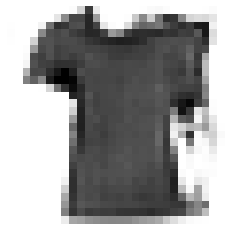

In [103]:
points = generate_latent_points(100,2)
x = generator.predict(points)

plt.axis("off")
plt.imshow(x[0,:,:,0], cmap="gray_r")


In [104]:
def interpolate_points(p1,p2,n_steps=10):
  ratios = np.linspace(0,1, num=n_steps)
  vectors = list()
  vectors_r = list()
  for ratio in ratios:
    v = (1.0 - ratio) * p1 + ratio * p2 
    vectors.append(v)
  return np.asarray(vectors)

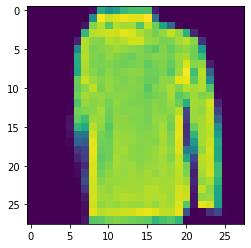

In [105]:
interpolated_points = interpolate_points(points[0], points[1])
x = generator.predict(interpolated_points)
x = (x+1) / 2.0

for i in range(len(interpolated_points)):
  plt.imshow(x[i,:,:,0])
  plt.savefig(str(i) + "one.png")
plt.show()